# $\Phi$-SO demo

## Packages import

In [1]:
# conda env
try:
    get_ipython().system('echo $CONDA_PREFIX')
except:
    pass

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO


In [2]:
try:
    %matplotlib inline
    #get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

In [3]:
# External packages
import torch
import numpy as np

# Pyplot
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

In [4]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [5]:
torch.cuda.is_available()

False

## Test case

In [6]:
data_size = int(1e3)

In [7]:
# Data points
data_lowbound, data_upbound = 0.2, 1
r  = np.random.uniform(data_lowbound, data_upbound, data_size)
x0_array = r
X_array = np.stack((x0_array,), axis=0)
rs   = 1.391
rho0 = 0.984
y_array = rho0 / ( (r/rs) * (1 + r/rs)**2 )

# One of many symbolic solutions:
target_program_str = ["div", "rho0", "mul", "div", "r", "rs", "n2", "add", "1", "div", "r", "rs"]
print(len(target_program_str))


12


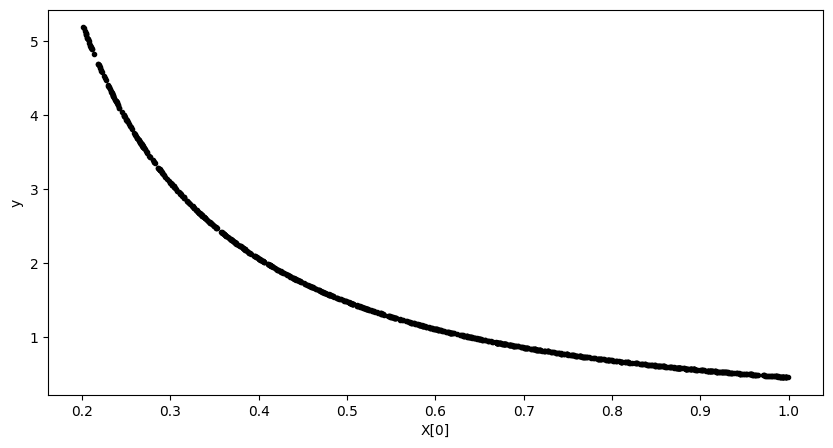

In [8]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [9]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array( 1.   )).to(DEVICE)
rho0   = torch.tensor(np.array( rho0 )).to(DEVICE)
rs     = torch.tensor(np.array( rs   )).to(DEVICE)

## Run config

### Library config

In [10]:
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt",], # "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"r" : 0         , },
                "input_var_units"      : {"r" : [1, 0, 0] , },
                "input_var_complexity" : {"r" : 1.        , },
                # constants
                "constants"            : {"1" : const1    , "rs" : rs        , "rho0" : rho0       ,},
                "constants_units"      : {"1" : [0, 0, 0] , "rs" : [1, 0, 0] , "rho0" : [-3, 1, 0] ,},
                "constants_complexity" : {"1" : 1.        , "rs" : 1.        , "rho0" : 1.         ,},
                ## free constants
                #"free_constants"            : {"m"              , "g"              ,},
                #"free_constants_init_val"   : {"m" : 1.         , "g" : 1.         ,},
                #"free_constants_units"      : {"m" : [0, 0, 1]  , "g" : [1, -2, 0] ,},
                #"free_constants_complexity" : {"m" : 1.         , "g" : 1.         ,},
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [-3, 1, 0],
                  "superparent_name"  : "rho",
                }

### Learning config

In [11]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, 
                 "zero_out_unphysical" : True, # PHYSICALITY
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                }

In [12]:
MAX_TRIAL_EXPRESSIONS = 2*1e6
BATCH_SIZE = int(1e4)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [13]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e9), #int(MAX_TRIAL_EXPRESSIONS/BATCH_SIZE),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

### Free constant optimizer config

In [14]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 30,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Priors config

In [15]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 8, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                #("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                #("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                #("NestedTrigonometryPrior", {"max_nesting" : 1}),           
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

### Cell config

In [16]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

### Logger

In [17]:
save_path_training_curves = 'nfw_curves.png'
save_path_log             = 'nfw.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 10,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [18]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

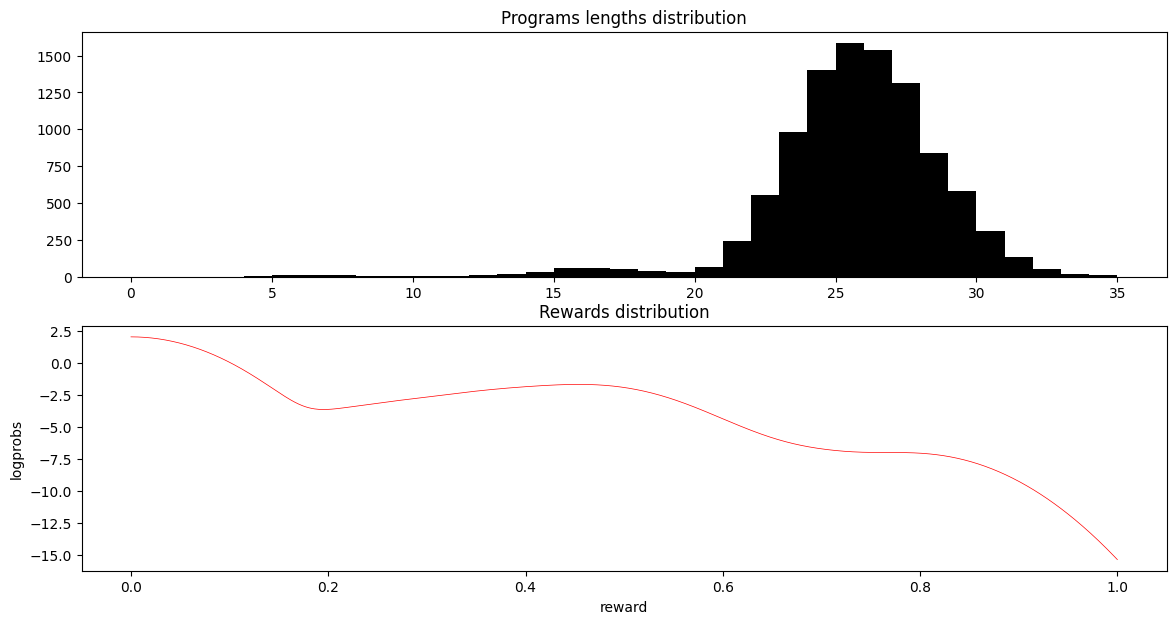

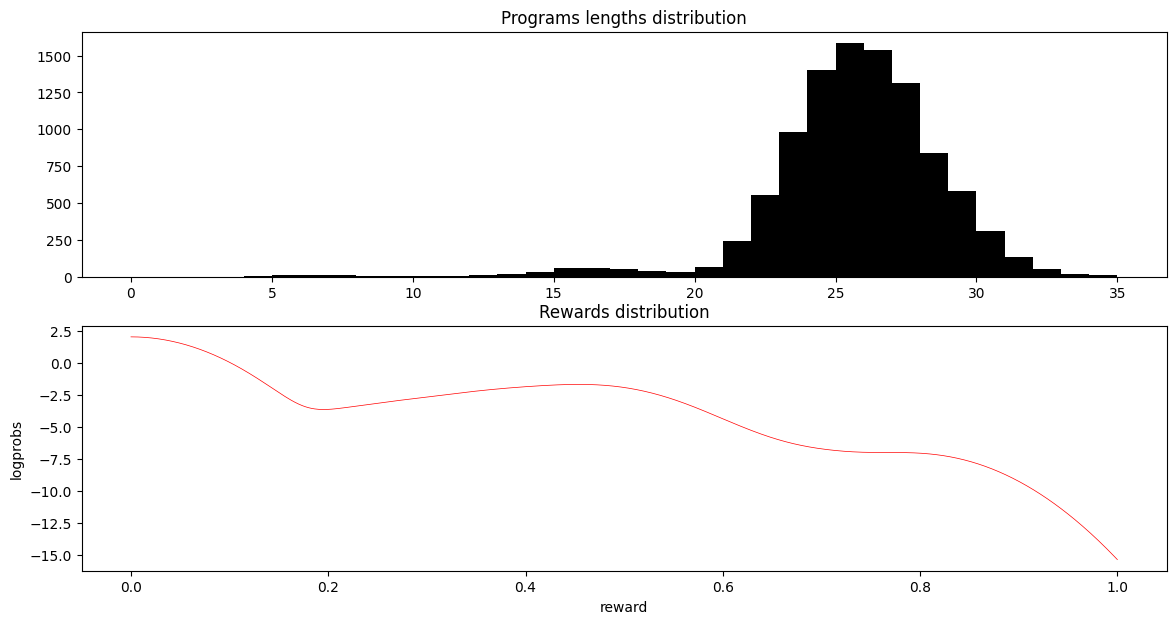

In [19]:
benchmark.dummy_epoch(X, y, run_config)

## Sanity checks

Data


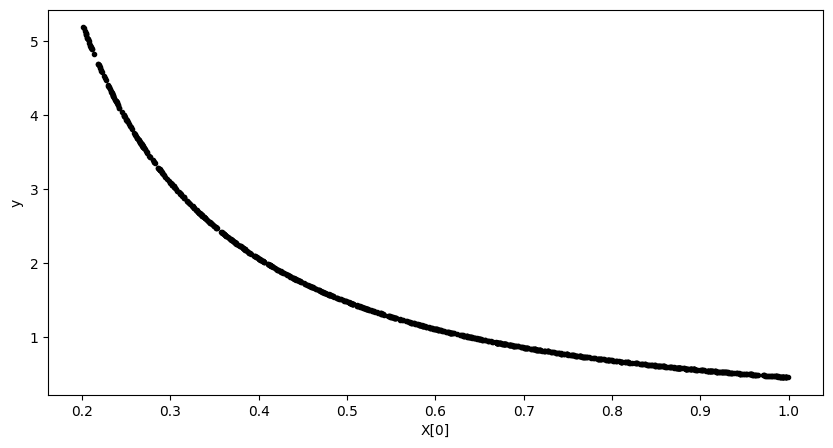

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, '1': 7, 'rs': 8, 'rho0': 9, 'r': 10}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt 1 rs rho0 r rho dummy -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 8, scale = 5)
- NoUselessInversePrior (['inv', 'n2', 'sqrt'] can not be child of ['inv', 'sqrt', 'n2'])
- PhysicalUnitsPrior
-------------------------- Dataset -------------------------
X        : torch.Size([1, 1000]) 
y_target : torch.Size([1000])
-------------------------- Programs ------------------------
[['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ...
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']]

-------------------------- Learning config ------------------------
{'batch_size': 1000

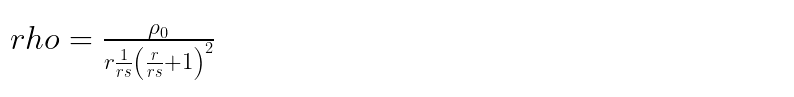

Simplified expression:


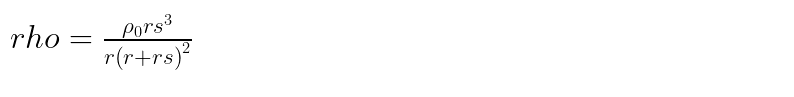

Ideal reward : 1.0


In [20]:
target_program = benchmark.sanity_check(X, y, run_config, 
                                        target_program_str = target_program_str,
                                        expected_ideal_reward = 1.,
                                       )

## Run

In [ ]:
rewards, candidates = physo.fit (X, y, run_config,
                                stop_reward = 1., 
                                stop_after_n_epochs = 30)

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00000 ===========
-> Time 9.56 s

Overall best  at R=0.797264
-> Raw expression : 
                         2
         ⎛             2⎞ 
         ⎜    ⎛   1   ⎞ ⎟ 
      rs⋅⎜1 + ⎜───────⎟ ⎟ 
         ⎜    ⎜⎛    1⎞⎟ ⎟ 
         ⎜    ⎜⎜1 - ─⎟⎟ ⎟ 
         ⎜    ⎜⎜    1⎟⎟ ⎟ 
         ⎜    ⎜⎜─────⎟⎟ ⎟ 
         ⎝    ⎝⎝  1  ⎠⎠ ⎠ 
-ρ₀ + ────────────────────
                 1        
             r⋅1⋅──       
                 ρ₀       

Best of epoch at R=0.797264
-> Raw expression : 
                         2
         ⎛             2⎞ 
         ⎜    ⎛   1   ⎞ ⎟ 
      rs⋅⎜1 + ⎜───────⎟ ⎟ 
         ⎜    ⎜⎛    1⎞⎟ ⎟ 
         ⎜    ⎜⎜1 - ─⎟⎟ ⎟ 
         ⎜    ⎜⎜    1⎟⎟ ⎟ 
         ⎜    ⎜⎜─────⎟⎟ ⎟ 
         ⎝    ⎝⎝  1  ⎠⎠ ⎠ 
-ρ₀ + ────────────────────
                 1        
             r⋅1⋅──       
                 ρ₀       


=========== Epoch 00001 ===========
-> Time 8.53 s

Overall best  at R=0.797264
-> Raw expression : 
                         2
         ⎛       

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00010 ===========
-> Time 15.14 s

Overall best  at R=0.806741
-> Raw expression : 
   ⎛         0.5    1  ⎞          
ρ₀⋅⎜- (1 + 1)    + ────⎟ - ρ₀ + ρ₀
   ⎜               ⎛r ⎞⎟          
   ⎜               ⎜──⎟⎟          
   ⎝               ⎝rs⎠⎠          

Best of epoch at R=0.797264
-> Raw expression : 
            ρ₀      
-ρ₀ + ──────────────
            r⋅ρ₀    
      r⋅────────────
        ⎛    r     ⎞
        ⎜──────────⎟
        ⎜     1    ⎟
        ⎜1⋅────────⎟
        ⎜  ⎛  rs  ⎞⎟
        ⎜  ⎜──────⎟⎟
        ⎜  ⎜    1 ⎟⎟
        ⎜  ⎜1⋅1⋅──⎟⎟
        ⎝  ⎝    ρ₀⎠⎠


=========== Epoch 00011 ===========
-> Time 8.43 s

Overall best  at R=0.806741
-> Raw expression : 
   ⎛         0.5    1  ⎞          
ρ₀⋅⎜- (1 + 1)    + ────⎟ - ρ₀ + ρ₀
   ⎜               ⎛r ⎞⎟          
   ⎜               ⎜──⎟⎟          
   ⎝               ⎝rs⎠⎠          

Best of epoch at R=0.797264
-> Raw expression : 
        ρ₀        
──────────────────
  1      ρ₀     1 
1⋅──⋅──────────

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00020 ===========
-> Time 14.94 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
──────⋅(r + rs)
⎛ ρ₀ ⎞         
⎜────⎟         
⎜  1 ⎟         
⎜1⋅──⎟         
⎝  rs⎠         

Best of epoch at R=0.797264
-> Raw expression : 
     1           1         
r⋅rs⋅──⋅1⋅rs⋅───────── - ρ₀
     rs      ⎛   1   ⎞     
             ⎜───────⎟     
             ⎜⎛  ρ₀ ⎞⎟     
             ⎜⎜─────⎟⎟     
             ⎜⎜⎛ r ⎞⎟⎟     
             ⎜⎜⎜───⎟⎟⎟     
             ⎜⎜⎜⎛1⎞⎟⎟⎟     
             ⎜⎜⎜⎜─⎟⎟⎟⎟     
             ⎝⎝⎝⎝r⎠⎠⎠⎠     


=========== Epoch 00021 ===========
-> Time 7.31 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
──────⋅(r + rs)
⎛ ρ₀ ⎞         
⎜────⎟         
⎜  1 ⎟         
⎜1⋅──⎟         
⎝  rs⎠         

Best of epoch at R=0.797264
-> Raw expression : 
      ρ₀⋅rs⋅rs
-ρ₀ + ────────
       r⋅1⋅rs 


=========== Epoch 00022 ===========
-> Time 7.49 s



/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00030 ===========
-> Time 16.00 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
──────⋅(r + rs)
⎛ ρ₀ ⎞         
⎜────⎟         
⎜  1 ⎟         
⎜1⋅──⎟         
⎝  rs⎠         

Best of epoch at R=0.797264
-> Raw expression : 
             1      
-ρ₀ + 1⋅────────────
        ⎛    r     ⎞
        ⎜──────────⎟
        ⎜⎛  r⋅rs  ⎞⎟
        ⎜⎜────────⎟⎟
        ⎜⎜⎛  r   ⎞⎟⎟
        ⎜⎜⎜──────⎟⎟⎟
        ⎜⎜⎜⎛ 1  ⎞⎟⎟⎟
        ⎜⎜⎜⎜────⎟⎟⎟⎟
        ⎜⎜⎜⎜  1 ⎟⎟⎟⎟
        ⎜⎜⎜⎜1⋅──⎟⎟⎟⎟
        ⎝⎝⎝⎝  ρ₀⎠⎠⎠⎠


=========== Epoch 00031 ===========
-> Time 8.86 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
──────⋅(r + rs)
⎛ ρ₀ ⎞         
⎜────⎟         
⎜  1 ⎟         
⎜1⋅──⎟         
⎝  rs⎠         

Best of epoch at R=0.797264
-> Raw expression : 
           1      
-ρ₀ + ────────────
      ⎛    r     ⎞
      ⎜──────────⎟
      ⎜⎛   ρ₀   ⎞⎟
      ⎜⎜────────⎟⎟
      ⎜⎜⎛  ρ₀  ⎞⎟⎟
 

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00040 ===========
-> Time 16.59 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
──────⋅(r + rs)
⎛ ρ₀ ⎞         
⎜────⎟         
⎜  1 ⎟         
⎜1⋅──⎟         
⎝  rs⎠         

Best of epoch at R=0.797264
-> Raw expression : 
        1   1    1    1   
-ρ₀ + 1⋅─⋅──────⋅─⋅───────
        1 ⎛ 1  ⎞ r ⎛  ρ₀ ⎞
          ⎜────⎟   ⎜─────⎟
          ⎝1⋅ρ₀⎠   ⎝ρ₀⋅rs⎠


=========== Epoch 00041 ===========
-> Time 9.19 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
──────⋅(r + rs)
⎛ ρ₀ ⎞         
⎜────⎟         
⎜  1 ⎟         
⎜1⋅──⎟         
⎝  rs⎠         

Best of epoch at R=0.797264
-> Raw expression : 
           1     1  1  
-ρ₀ + rs⋅1⋅──⋅rs⋅─⋅────
           rs    r   1 
                   1⋅──
                     ρ₀


=========== Epoch 00042 ===========
-> Time 8.46 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
─

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00050 ===========
-> Time 16.48 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
──────⋅(r + rs)
⎛ ρ₀ ⎞         
⎜────⎟         
⎜  1 ⎟         
⎜1⋅──⎟         
⎝  rs⎠         

Best of epoch at R=0.797264
-> Raw expression : 
         1          1        
-ρ₀ + 1⋅────⋅────────────────
        ⎛1 ⎞ ⎛      1       ⎞
        ⎜──⎟ ⎜──────────────⎟
        ⎝ρ₀⎠ ⎜       1      ⎟
             ⎜1⋅────────────⎟
             ⎜  ⎛    r     ⎞⎟
             ⎜  ⎜──────────⎟⎟
             ⎜  ⎜⎛   1    ⎞⎟⎟
             ⎜  ⎜⎜────────⎟⎟⎟
             ⎜  ⎜⎜⎛  ρ₀  ⎞⎟⎟⎟
             ⎜  ⎜⎜⎜──────⎟⎟⎟⎟
             ⎜  ⎜⎜⎜⎛ rs ⎞⎟⎟⎟⎟
             ⎜  ⎜⎜⎜⎜────⎟⎟⎟⎟⎟
             ⎜  ⎜⎜⎜⎜⎛1 ⎞⎟⎟⎟⎟⎟
             ⎜  ⎜⎜⎜⎜⎜──⎟⎟⎟⎟⎟⎟
             ⎝  ⎝⎝⎝⎝⎝ρ₀⎠⎠⎠⎠⎠⎠


=========== Epoch 00051 ===========
-> Time 9.65 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
──────⋅(r + rs)
⎛ ρ₀ ⎞         
⎜────⎟     

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00060 ===========
-> Time 17.15 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
──────⋅(r + rs)
⎛ ρ₀ ⎞         
⎜────⎟         
⎜  1 ⎟         
⎜1⋅──⎟         
⎝  rs⎠         

Best of epoch at R=0.797264
-> Raw expression : 
           rs     
-ρ₀ + ────────────
      ⎛    r     ⎞
      ⎜──────────⎟
      ⎜⎛   ρ₀   ⎞⎟
      ⎜⎜────────⎟⎟
      ⎜⎜⎛  ρ₀  ⎞⎟⎟
      ⎜⎜⎜──────⎟⎟⎟
      ⎜⎜⎜   1  ⎟⎟⎟
      ⎜⎜⎜1⋅────⎟⎟⎟
      ⎜⎜⎜    1 ⎟⎟⎟
      ⎜⎜⎜  1⋅──⎟⎟⎟
      ⎝⎝⎝    ρ₀⎠⎠⎠


=========== Epoch 00061 ===========
-> Time 7.84 s

Overall best  at R=0.854094
-> Raw expression : 
    -r + rs    
───────────────
  r            
──────⋅(r + rs)
⎛ ρ₀ ⎞         
⎜────⎟         
⎜  1 ⎟         
⎜1⋅──⎟         
⎝  rs⎠         

Best of epoch at R=0.797264
-> Raw expression : 
                rs         
-ρ₀ + ─────────────────────
      ⎛         ρ₀        ⎞
      ⎜───────────────────⎟
      ⎜⎛        1        ⎞⎟
      ⎜⎜────────────

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x126ae09d0> (for post_execute):


KeyboardInterrupt: 

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


## Results

### Run plot

In [ ]:
run_visualiser.make_visualisation()
run_visualiser.save_visualisation()
run_visualiser.save_data()

### Pareto Front

In [ ]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = np.log(pareto_front_rmse)
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("log(RMSE)")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

In [ ]:
plot_pareto_front(run_logger)


In [ ]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)

### Symbolic equivalence

In [ ]:
best_prog_sympy   = candidates[-1] .get_infix_sympy(do_simplify=True)
target_prog_sympy = target_program .get_infix_sympy(do_simplify=True)

In [ ]:
target_prog_sympy

In [ ]:
best_prog_sympy

In [ ]:
target_prog_sympy == best_prog_sympy

In [ ]:
hall_of_fame = run_logger.hall_of_fame

In [ ]:
for i in range(len(hall_of_fame)):
    print(hall_of_fame[i].get_infix_sympy(do_simplify=False))

In [ ]:
eq = hall_of_fame[i].get_infix_sympy(do_simplify=True)

In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    print("g", prog.free_const_values[0])
    print("m", prog.free_const_values[1])